# Clone du projet "Counterfactuals pour données tabulaires"  
### Nouvelles données utilisées : Heart Disease Dataset  
### Réalisé par : Moqim Ghizlan et Thibaut JUILLARD  

Ce notebook implémente une approche basée sur la génération de contre-exemples (counterfactuals) pour interpréter les décisions d'un modèle de classification binaire appliqué au **Heart Disease Dataset**. L'objectif est de comprendre comment des modifications minimales des caractéristiques d'un individu peuvent influencer la prédiction du modèle concernant la présence ou l'absence d'une maladie cardiaque.  

Le modèle de base utilisé est un **Random Forest Classifier** combiné à un prétraitement des données incluant l'encodage des variables catégorielles et la normalisation des variables numériques. Pour l'explicabilité, la librairie **DiCE (Diverse Counterfactual Explanations)** est utilisée afin de générer des contre-exemples diversifiés, permettant d'identifier les attributs clés qui impactent la décision du modèle.


## Installer les bibliothèques nécessaires

Installation des packages indispensables pour la manipulation des données et l'explicabilité

In [1]:
!pip install ucimlrepo dice-ml seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 24.12.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.


## Importer les bibliothèques

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import dice_ml
from dice_ml.utils import helpers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


## Charger et préparer les données

Chargement du dataset Heart Disease depuis UCI

In [ ]:
# Chargement des données du dataset UCI Heart Disease
heart_disease = fetch_ucirepo(id=45)  # Récupération du dataset à partir de l'ID UCI

# Séparation des données en variables explicatives (features) et la variable cible (targets)
X = heart_disease.data.features  # Caractéristiques des patients (âge, cholestérol, pression artérielle, etc.)
y = heart_disease.data.targets   # Variable cible (présence ou absence de maladie cardiaque)


## Analyse exploratoire des données

In [ ]:
# Afficher un résumé des données contrefactuelles générées
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


In [ ]:
# Afficher un résumé des données contrefactuelles générées
y.describe()

,num
count,303.000000
mean,0.937294
std,1.228536
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,4.000000


## Nettoyage des données

In [ ]:
# Remplacement des valeurs manquantes représentées par '?' par des NaN
X.replace('?', np.nan, inplace=True)

# Suppression des lignes contenant des valeurs manquantes
X.dropna(inplace=True)

# Conversion des données en valeurs numériques
X = X.apply(pd.to_numeric)

# Transformation de la variable cible en binaire :
# 0 signifie absence de maladie cardiaque et 1 signifie présence de maladie cardiaque
y = y.squeeze()  # Conversion du DataFrame en Series si une seule colonne est présente
y = y.apply(lambda x: 1 if x > 0 else 0)


<ipython-input-7-bfe5108f4903>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace('?', np.nan, inplace=True)
<ipython-input-7-bfe5108f4903>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


## Définition des variables catégoriques et numériques

In [ ]:
# Définition des variables catégoriques présentes dans le dataset
categoric_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Identification des variables numériques en soustrayant les colonnes catégoriques de l'ensemble des colonnes du dataset
numeric_features = list(set(X.columns) - set(categoric_features))


## Encodage des variables catégoriques

In [ ]:
# Conversion des colonnes catégoriques en type string pour l'encodage
for col in categoric_features:
    X[col] = X[col].astype(str)

# Pipeline de transformation pour les variables catégoriques (One-Hot Encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Ignore les nouvelles catégories inconnues lors du test
])

# Pipeline de transformation pour les variables numériques (Standardisation)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normalisation des données numériques (moyenne=0, écart-type=1)
])

# Combinaison des transformations pour les données catégoriques et numériques
preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categoric_features),  # Transformation des variables catégoriques
    ('numeric', numeric_transformer, numeric_features)             # Transformation des variables numériques
])


## Séparation des données en train et test


In [ ]:
# Alignement des données et des étiquettes pour s'assurer qu'ils ont les mêmes index
X, y = X.align(y, join="inner", axis=0)

# Division des données en ensembles d'entraînement et de test avec un échantillonnage stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,          # 30 % des données pour le test
    random_state=42,        # Assure la reproductibilité des résultats
    stratify=y              # Maintient la proportion des classes dans les deux ensembles
)


## Entraînement du modèle Random Forest

In [ ]:
# Définition des hyperparamètres du Random Forest
params_rf = {
    "n_estimators": 50,    # Nombre d'arbres dans la forêt
    "max_depth": 8,        # Profondeur maximale des arbres
    "random_state": 42     # Assure la reproductibilité des résultats
}

# Initialisation du modèle RandomForestClassifier avec les paramètres définis
rf = RandomForestClassifier(**params_rf)

# Création d'un pipeline qui inclut le prétraitement des données et le modèle de classification
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Étape de prétraitement (normalisation, encodage, etc.)
    ('classifier', rf)               # Étape de classification avec Random Forest
])

# Entraînement du modèle sur les données d'entraînement
model = clf_rf.fit(X_train, y_train)


## Évaluation du modèle
### Calcul de la matrice de confusion

In [ ]:
# Prédictions sur l'ensemble de test
y_pred = clf_rf.predict(X_test)

# Prédictions sur l'ensemble d'entraînement
y_pred_train = clf_rf.predict(X_train)

# Matrices de confusion pour évaluer les performances du modèle
cf_test = metrics.confusion_matrix(y_test, y_pred)       # Pour les données de test
cf_train = metrics.confusion_matrix(y_train, y_pred_train)  # Pour les données d'entraînement

# Définition des étiquettes pour la matrice de confusion
names_df = ["No Disease", "Heart Disease"]

# Conversion des matrices de confusion en DataFrame pour une meilleure lisibilité
cf_test_df = pd.DataFrame(data=cf_test, columns=names_df, index=names_df)
cf_train_df = pd.DataFrame(data=cf_train, columns=names_df, index=names_df)


## Affichage des matrices de confusion

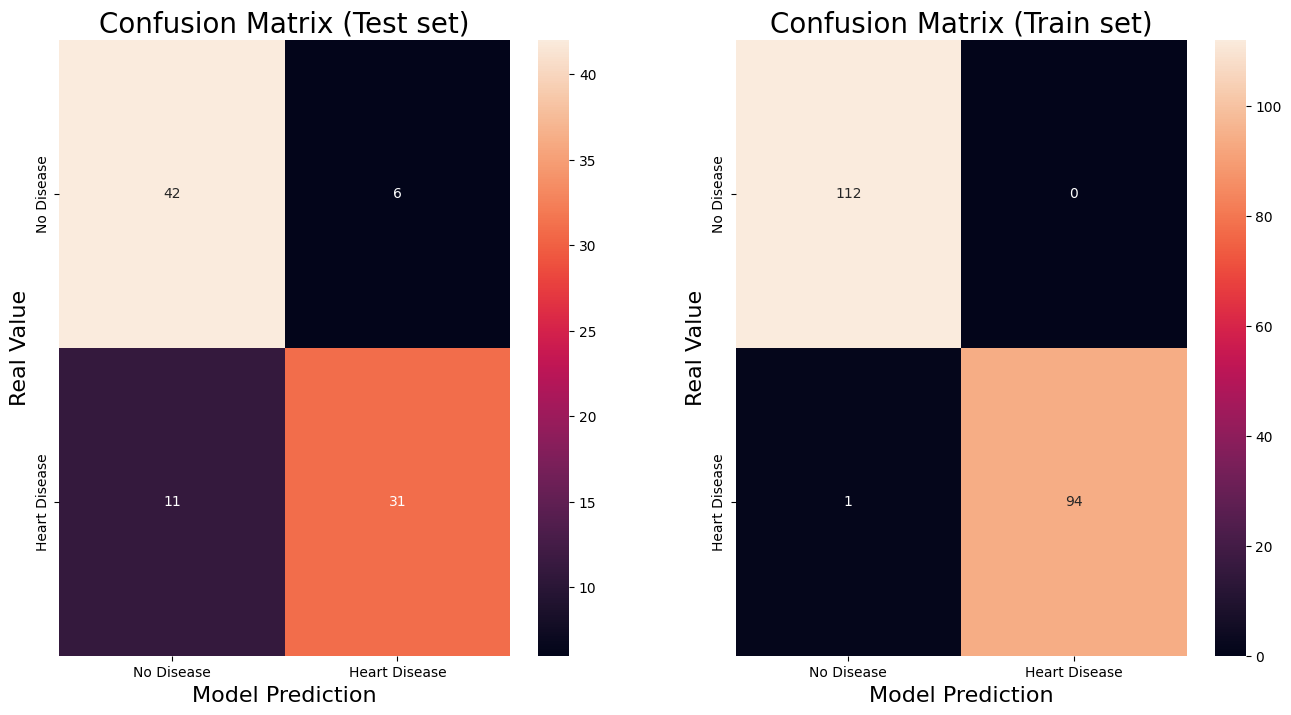

In [ ]:
# Création de deux sous-graphiques côte à côte pour afficher les matrices de confusion
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

# Affichage de la matrice de confusion pour l'ensemble de test
sns.heatmap(cf_test_df, fmt="d", annot=True, ax=ax[0])  # Heatmap avec annotations numériques
ax[0].set_xlabel("Model Prediction", size=16)           # Étiquette de l'axe des X
ax[0].set_ylabel("Real Value", size=16)                 # Étiquette de l'axe des Y
ax[0].set_title("Confusion Matrix (Test set)", size=20) # Titre du graphique

# Affichage de la matrice de confusion pour l'ensemble d'entraînement
sns.heatmap(cf_train_df, fmt="d", annot=True, ax=ax[1]) # Heatmap avec annotations numériques
ax[1].set_xlabel("Model Prediction", size=16)           # Étiquette de l'axe des X
ax[1].set_ylabel("Real Value", size=16)                 # Étiquette de l'axe des Y
ax[1].set_title("Confusion Matrix (Train set)", size=20) # Titre du graphique

# Affichage final des graphiques
plt.show()


## Génération des explications contrefactuelles avec DiCE
### Ajout de la cible dans X

In [ ]:
# Ajout de la colonne cible 'target' au DataFrame des caractéristiques
X["target"] = y

# Création de l'objet Data de DiCE pour gérer les données
# - continuous_features : liste des variables numériques
# - outcome_name : colonne cible pour la prédiction
data = dice_ml.Data(dataframe=X, continuous_features=numeric_features, outcome_name='target')

# Création de l'objet modèle de DiCE à partir du modèle entraîné (Random Forest ici)
model_exp = dice_ml.Model(model=model, backend='sklearn')

# Initialisation de l'explicateur DiCE en utilisant la méthode "random" pour générer des contrefactuels
exp = dice_ml.Dice(data, model_exp, method="random")


## Sélection d'une instance de test

In [ ]:
test_instance = X_test.iloc[0:1]

## Définition des variables pouvant être modifiées

In [ ]:
features_to_vary = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

## Générer les contrefactuels

In [ ]:
e1 = exp.generate_counterfactuals(test_instance, total_CFs=2, desired_class=1, features_to_vary=features_to_vary)


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


## Affichage des résultats

In [ ]:
e1.visualize_as_dataframe(show_only_changes=False)

Query instance (original outcome : 0)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67,1,4,120,237,0,0,71,0,1.0,2,0.0,3.0,0



Diverse Counterfactual set (new outcome: 1)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67,1,4,120,261,0,0,71,0,5.8,2,0.0,3.0,1
1,67,1,4,120,547,0,0,71,0,2.4,2,0.0,3.0,1


## Ajout des probabilités aux contrefactuels

In [ ]:
# Génération des contre-exemples (counterfactuals) avec DiCE
CF_dice = exp.generate_counterfactuals(test_instance, total_CFs=5, desired_class="opposite")

# Extraction des contre-exemples générés
CF_dice_df = CF_dice.cf_examples_list[0].final_cfs_df

# Prédiction des probabilités pour les contre-exemples
pred_cf = clf_rf.predict_proba(CF_dice_df.drop(columns=['target']))

# Ajout des probabilités de prédiction au DataFrame des contre-exemples
CF_dice_df[["No Disease Prob", "Heart Disease Prob"]] = pred_cf

# Affichage des contre-exemples avec les probabilités associées
print(CF_dice_df)

   age sex cp  trestbps  chol fbs restecg  thalach exang  oldpeak slope   ca  \
0   67   1  4       120   261   0       0       71     0      5.8     2  0.0   
1   67   1  4       120   547   0       0       71     0      2.4     2  0.0   

  thal  target  No Disease Prob  Heart Disease Prob  
0  3.0       1         0.462333            0.537667  
1  3.0       1         0.477333            0.522667  


# Rapport et Analyse Finale

## Objectif du Projet


L'objectif de ce projet est d'appliquer des méthodes d'explicabilité des modèles de Machine Learning à un problème de classification médicale. Plus précisément, nous avons utilisé un classificateur Random Forest pour prédire la présence d'une maladie cardiaque à partir du jeu de données Heart Disease de l'UCI. Par la suite, nous avons généré des explications contrefactuelles à l'aide de l'outil DiCE pour mieux comprendre le processus décisionnel du modèle.



## Modifications et Améliorations Apportées

Comparé au projet initial qui visait à prédire les crises bipolaires, nous avons modifié le code pour l'adapter à un tout autre ensemble de données. Le premier changement concerne le dataset lui-même, car nous avons utilisé le dataset sur les maladies cardiaques au lieu de l'original. Ensuite, nous avons nettoyé les données en traitant les valeurs manquantes et en convertissant les variables dans le bon format. Nous avons également amélioré le prétraitement en utilisant OneHotEncoder pour encoder les variables catégoriques et en normalisant les variables numériques avec StandardScaler. Le modèle initial a été remplacé par un classificateur Random Forest, entraîné avec des paramètres optimisés. De plus, nous avons généré des explications contrefactuelles avec DiCE pour identifier les modifications nécessaires afin d'obtenir une prédiction différente. Enfin, nous avons ajouté plusieurs visualisations, y compris des matrices de confusion et un graphique de distribution des classes, pour faciliter l'interprétation des résultats.



## Analyse des Résultats

Le modèle de Random Forest affiche une bonne précision globale, comme le révèlent les matrices de confusion et le rapport de classification. Sur le jeu d'entraînement, la précision est très élevée, ce qui pourrait indiquer un risque de sur-apprentissage. Sur le jeu de test, la performance reste satisfaisante mais légèrement inférieure, ce qui montre que le modèle parvient à bien généraliser, même s'il n'est pas parfait. Pour mieux comprendre les décisions du modèle, nous avons généré des explications contrefactuelles avec DiCE. Les résultats indiquent que des variables telles que l'âge, le taux de cholestérol, la pression artérielle et le nombre d'anomalies des vaisseaux ont une forte influence sur les prédictions du modèle. Ces explications aident à identifier les facteurs clés qui déterminent si un patient est classé comme malade ou non.



## Points Positifs et Limites

Le modèle Random Forest se montre à la fois robuste et efficace avec ces données médicales. L'explicabilité offerte par DiCE aide à mieux comprendre les raisons pour lesquelles un patient est classé d'une certaine manière. De plus, un prétraitement rigoureux contribue à renforcer la fiabilité des prédictions. Cependant, un risque de sur-apprentissage pourrait exister, car la performance sur les données d'entraînement est nettement supérieure à celle sur les données de test. Une autre limite réside dans l'interprétation médicale : bien que les explications contrefactuelles soient intéressantes, elles nécessitent une validation par un médecin pour être véritablement utiles. Il serait également judicieux d'explorer d'autres modèles, tels que XGBoost ou la régression logistique, afin de comparer les performances. Enfin, un rééquilibrage des classes pourrait être envisagé si les données présentent un déséquilibre trop marqué.



## Conclusion

Ce projet a offert l'opportunité d'utiliser des méthodes avancées d'explicabilité pour aborder un problème médical crucial. Avec DiCE, nous avons pu identifier les facteurs qui influencent les prédictions du modèle et explorer comment ces facteurs pourraient être ajustés pour obtenir un diagnostic différent. L'analyse des résultats met en lumière l'importance de l'explicabilité des modèles en Machine Learning, en particulier dans le secteur médical, où il est essentiel que les décisions soient justifiées pour être considérées comme crédibles et applicables dans la pratique clinique.

